# CIS 390 - Supervised Machine Learning Final Project
In this file, we'll take our results from the `FinalProject_DataQualityReport.ipynb` and use that `DataFrame` to build and evaluate a model that can predict the resale price of a motorcycle. For this project, we will be building regression models since our target feature is a continuous variable. We will also create visualizations that will help us better understand the data. This will allow us to complete the "Modeling", "Evaluation", and "Deployment" stages of the **CRISP-DM** process.

## Getting Set Up
To get started, we will load in necessary libraries for this jupyter notebook, and load in the dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("Data/abt_motorcycle_prices.csv")
df.head()

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,age,usage_intensity,brand
0,'Honda Dio',45000,2017,1,0,5650,72752.5,7,807.142857,7
1,'Yamaha Fazer FI V 2.0 [2016-2018]',65000,2015,1,0,23000,89643.0,9,2555.555556,18
2,'Yamaha SZ [2013-2014]',20000,2011,1,1,21000,72752.5,13,1615.384615,18
3,'Honda CB Twister',18000,2010,1,0,60000,53857.0,14,4285.714286,7
4,'Honda CB Hornet 160R',78500,2018,1,0,17000,87719.0,6,2833.333333,7


## Prepping The Data For Modeling
We will now begin the process of building the model. This will first require us to normalize numeric features, making them suitable for regression models sensitive to feature scales. We can use a `MinMaxScaler` for this. We will also split up the data into training and testing splits during this step.

In [26]:
numeric_features = ['km_driven', 'ex_showroom_price', 'age', 'usage_intensity']

scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

print("Normalized Numeric Features:\n", df[numeric_features].describe())

Normalized Numeric Features:
         km_driven  ex_showroom_price         age  usage_intensity
count  837.000000         837.000000  837.000000       837.000000
mean     0.333768           0.498224    0.306346         0.387610
std      0.215415           0.214192    0.217960         0.215490
min      0.000000           0.000000    0.000000         0.000000
25%      0.163133           0.311944    0.117647         0.224563
50%      0.297032           0.563009    0.294118         0.358217
75%      0.456717           0.563009    0.470588         0.529359
max      1.000000           1.000000    1.000000         1.000000


In [40]:
X = df.drop(columns=['selling_price', 'name'])
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# df_test used for visualization purposes
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['actual_selling_price'] = y_test

# verify that shapes for splitting are correct
print("X train:", X_train.shape)
print("X test:", X_test.shape)
print("Y train:", y_train.shape)
print("Y test:", y_test.shape)

df_test

X train: (669, 8)
X test: (168, 8)
Y train: (669,)
Y test: (168,)


,year,seller_type,owner,km_driven,ex_showroom_price,age,usage_intensity,brand,actual_selling_price
458,2007,1,0,0.274715,0.563009,0.705882,0.189232,3,22000
274,2016,1,0,0.319348,1.000000,0.176471,0.478933,3,60000
461,2014,1,1,0.386298,0.563009,0.294118,0.462125,6,30000
476,2017,1,0,0.419772,0.563009,0.117647,0.721457,15,50000
279,2019,1,0,0.163133,0.563009,0.000000,0.394890,3,45000
...,...,...,...,...,...,...,...,...,...
230,2014,1,0,0.162743,0.563009,0.294118,0.192716,7,40000
669,2017,1,0,0.313211,0.563009,0.117647,0.538003,3,60000
686,2019,1,0,0.062709,0.563009,0.000000,0.152846,15,105000
332,2018,1,0,0.151975,0.311944,0.058824,0.305244,7,50000


## Building A Baseline Model
We will build two different models for this project, one a more simple model, and another that should work a bit better. We will start with a simple linear regression model to get a baseline and see if we can improve on the performance of that. In this stage of the project, we will train the model, allow it to make predictions, evaluate it, and go from there.

In [41]:
# initialize model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# make predictions
y_pred_train = linear_model.predict(X_train)
y_pred_test = linear_model.predict(X_test)

# evaluate model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Training MSE:", mse_train)
print("Test MSE:", mse_test)
print("Test MAE:", mae_test)
print("Test R²:", r2_test)

Training MSE: 316384574.1729663
Test MSE: 297341310.3410594
Test MAE: 12022.443594646873
Test R²: 0.43852796740612854


So let's interpret these results. The values for the mean squared error are the average squared difference between predicted and actual selling prices in training and testing sets. The large value indicates that there is high variability in prediction errors. One positive is that the `mse_train` and `mse_test` are relatively close, suggesting the model is not overfitting or underfitting. 

The mean absolute error is the average absolute error in predicted resale prices. So on average, our predictions are off by around \\$12,022. This leaves a little bit of room for improvement. 

The R² measures how well the model explains variance in the target variable. The value of 0.439 indicates the model explains 43.9% of the variance in resale prices based on the features. This means the model is likely not fully capturing a relationship between features and the target. Let's build some visualizations to help us see this more clearly:

### Plot 1: Residual Plot
This plot will help us to identify if errors are randomly distributed or show patterns. We can see from the results below that the errors are pretty randomly distributed throughout. This indicates that the model's errors are randomly distributed and is capturing some form of relationship between features.

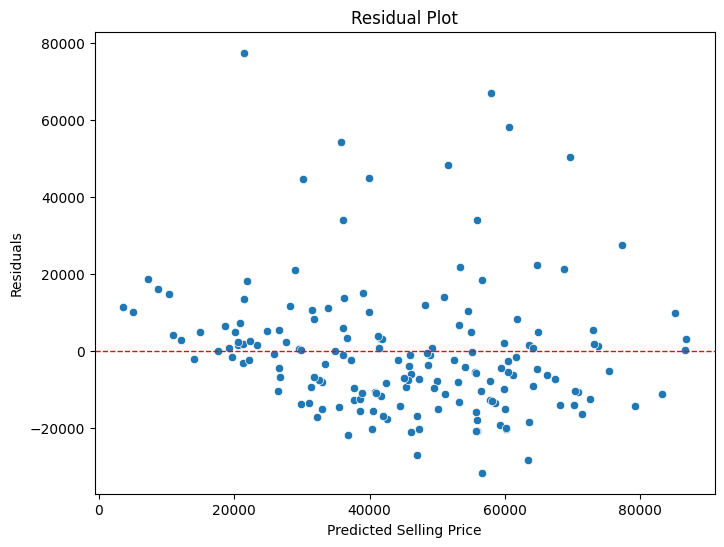

In [43]:
# residuals tell us how much we were off by
df_test['predicted_selling_price'] = y_pred_test
df_test['residuals'] = df_test['actual_selling_price'] - df_test['predicted_selling_price']

# building the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_test['predicted_selling_price'], y=df_test['residuals'])
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Selling Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Plot 2: Coefficient Analysis
This plot will help us to visualize **feature importance**, aka what features are most important to the model. We will create a bar chart of the model's coefficients to see which features have the most significant impact on predictions and their directions. We can see from looking at the plot that `ex_showroom_price`, `km_driven`, and `usage_intensity` have a heavy impact on the model, while some features, such as `seller_type`, seem to have no effect at all on the model.

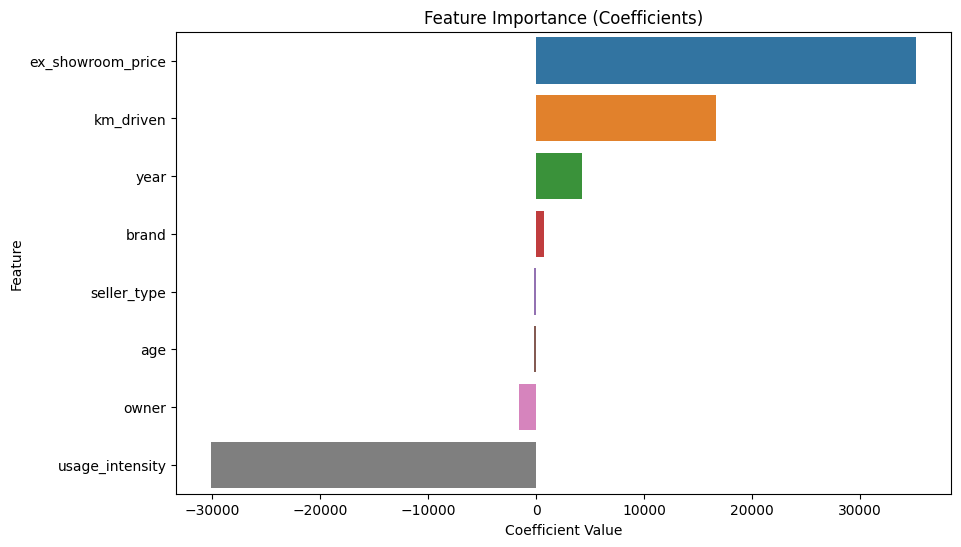

In [46]:
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': linear_model.coef_})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance (Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

### Plot 3: Predicted vs. Actual Values
This scatter plot will compare predicted selling prices to actual selling prices. Ideally, points should align along the diagonal line (y = x). We can see from the plot that this didn't exactly happen. While clearly the model is picking up a relationship, it consistently predicted a selling price higher than the actual selling price.  

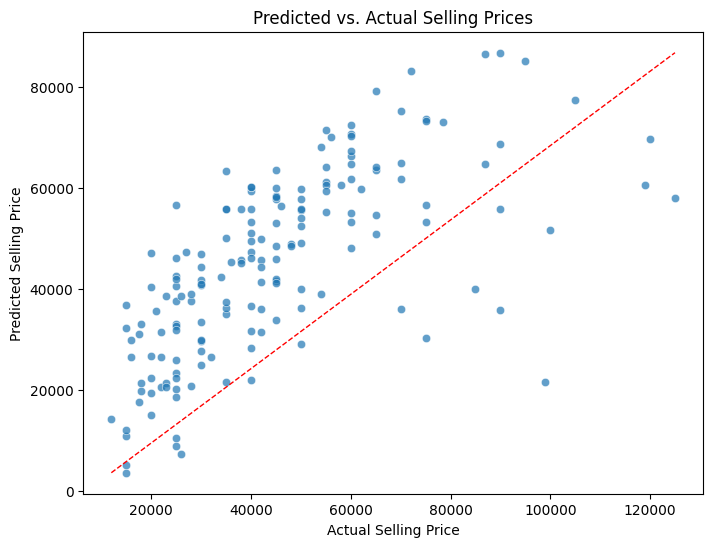

In [47]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_test['actual_selling_price'], y=df_test['predicted_selling_price'], alpha=0.7)
plt.plot([df_test['actual_selling_price'].min(), df_test['actual_selling_price'].max()],
         [df_test['predicted_selling_price'].min(), df_test['predicted_selling_price'].max()],
         color='red', linestyle='--', linewidth=1)
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Predicted vs. Actual Selling Prices')
plt.show()

## Building A Better Model
We will now build a new model that can capture a non-linear relationship. We can use a `RandomForestRegressor` to do this. This model naturally handles non-linear interactions and often performs well without much feature engineering. We will start this process by training and evaluating the model, and will conclude with some visualizations.

In [61]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=123)
random_forest_model.fit(X_train, y_train)

# make predictions
y_pred_train_rf = random_forest_model.predict(X_train)
y_pred_test_rf = random_forest_model.predict(X_test)

# evaulate model
train_mse_rf = mean_squared_error(y_train, y_pred_train_rf)
test_mse_rf = mean_squared_error(y_test, y_pred_test_rf)
test_mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)

print(f"Training MSE: {train_mse_rf}")
print(f"Test MSE: {test_mse_rf}")
print(f"Test MAE: {test_mae_rf}")
print(f"Test R²: {test_r2_rf}")

Training MSE: 25948175.99727145
Test MSE: 140414441.1921816
Test MAE: 8740.113792517006
Test R²: 0.7348542602059687
Mean CV MSE: 174436116.99696192


These results are definitely an improvement from the linear regression model we built earlier, but still have room for improvement. The training mean squared error is much lower than the testing mean squared error, indicating there is likely some overfitting to the training data. However, there are also some good signs here. The training mean squared error is actually pretty low, suggesting the model is fitting the training data well. The mean absolute error is 8740.11, which means we're off on our prediction by an average of \\$8740, which is a good bit better than the \\$12,022 from the linear regression model. The R² value is also much higher, showing that 73.5% of the variance in the target variable can be explained by the model, compared to 43.9% from the linear regression model. 

Let's see if we can improve on these results by performing some **hyperparameter tuning**. We can play around with the hyperparameters of the `RandomForestRegressor` using a `GridSearchCV`. This will allow us to see what parameters will result in the best performing model.

In [67]:
# WARNING: this could take a while to run depending on your machine
# Took around 10 mins to run on mine (my GPU is pretty low-end, however)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=123), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_random_forest = grid_search.best_estimator_

print("Best Model:", best_random_forest)
print(f"Best Parameters: {grid_search.best_params_}")

Best Model: RandomForestRegressor(max_depth=10, max_features=None, min_samples_leaf=5,
                      min_samples_split=5, n_estimators=300, random_state=123)
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}


We can see after using the `GridSearchCV` we get a nice output telling us what parameters will work best for our model. According to the output, we should be using a max depth of 10, a value of `None` for the max features, 1 as the minimum number of samples at a leaf node, 5 as the minimum number of samples required to split a node, and 300 trees in our forest. Let's put this to the test and build a new model using the parameters recommended to us.

In [69]:
model = RandomForestRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=300,
    random_state=123
)
model.fit(X_train, y_train)

# make predictions
y_pred_train_finalModel = model.predict(X_train)
y_pred_test_finalModel = model.predict(X_test)

# evaluate model
train_mse = mean_squared_error(y_train, y_pred_train_finalModel)
test_mse = mean_squared_error(y_test, y_pred_test_finalModel)
test_mae = mean_absolute_error(y_test, y_pred_test_finalModel)
test_r2 = r2_score(y_test, y_pred_test_finalModel)

print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test R²: {test_r2}")

Training MSE: 49180476.168726474
Test MSE: 136983161.62909105
Test MAE: 8663.472126725826
Test R²: 0.7413335735192665


We can see a slight improvement across the board in our model. Our training mean squared error is higher than the previous training mean squared error, indicating that it reduced overfitting. The test mean squared error decreased slightly. The mean absolute error also decreased, down to missing by an average of \\$8663 on our price estimation. The R² value also increased slightly to 74.1%. All of these metrics indicate a better performing model than before.

## Visualizing The Model
Let's create some visualizations to help us understand where our model succeeds and fails. We will focus on **feature importance**, **residual analysis**, **predictions vs actual prices**, and **error distribution**, similar to how we visualized our linear model from earlier.

### Plot 1: Feature Importance
This plot will help to identify what features drive the predictions. This will aid in interpretability and feature selection. We can see when comparing and contrasting this visualization with the one from the linear regression model that while there are some similarities, this one is very different. In particular, the `brand` feature that we engineered earlier is the most important feature to this model, whereas it was not important at all to the other model.

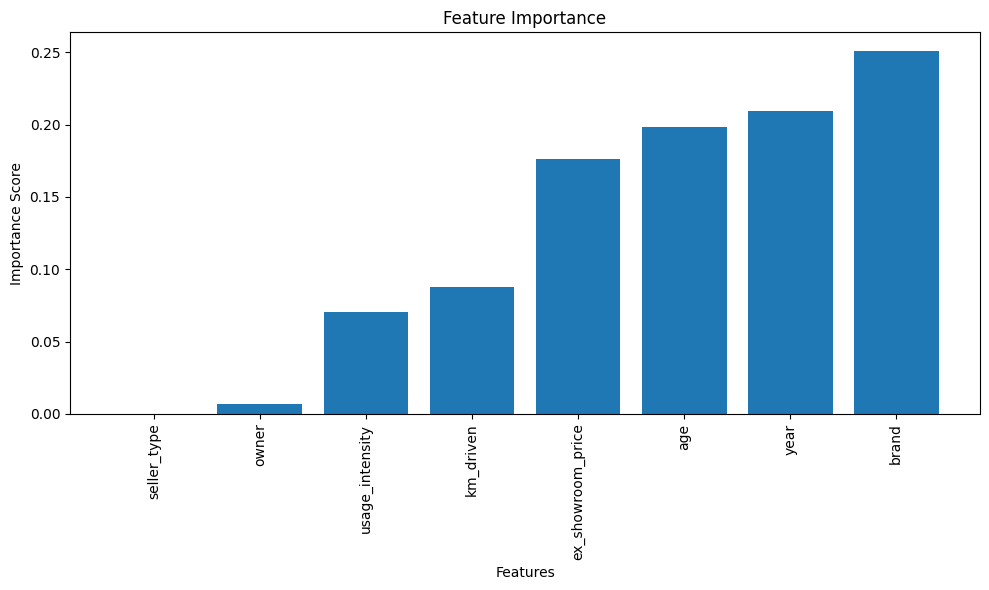

In [74]:
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::1]
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.bar(range(len(features)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(features)), features[sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

### Plot 2: Residual Analysis
This will help us to check if residuals are randomly distributed or skewed in any way. We're basically just doing some pattern checking here. A good model will show that the residuals are distributed randomly. As we can see below, the distribution here is fairly random. There are a lot more datapoints towards the lower predicted values side, which is good because our linear regression model had a tendency to predict values much higher than they actually were.

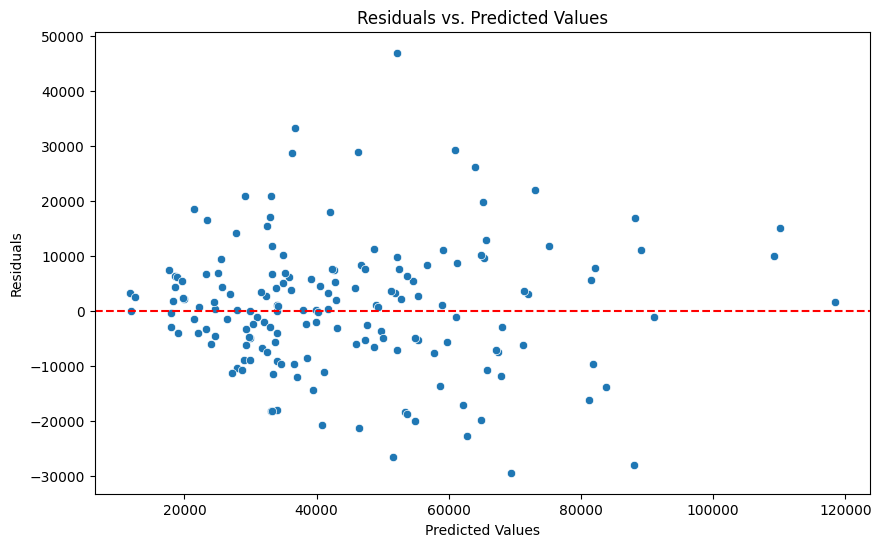

In [77]:
residuals = y_test - y_pred_test_finalModel

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test_finalModel, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

### Plot 3: Predicted vs. Actual
This plot will plot predicted values against actual values to evaluate the model's fit. This will indicate how closely predictions align with the actual values.We can see below that this plot looks much better than its corresponding plot generated earlier. This shows that our errors don't really lean heavily in one direction, meaning we're usually making a better prediction than our linear regression model was.

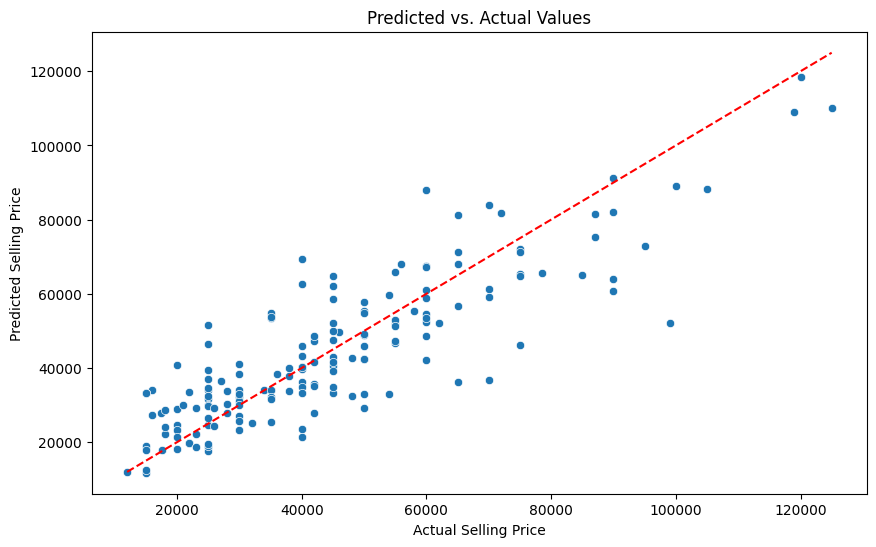

In [79]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test_finalModel)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs. Actual Values")
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.show()

### Plot 4: Error Distribution
This plot highlights potential skewness or bias in errors. This can help us to assess normality and bias. We can see this distribution fits very well. It looks like basically a textbook normal distribution which indicates that our errors aren't distributed heavily in one way, and therefore our model is fitting a relationship between descriptive features and the target feature well.

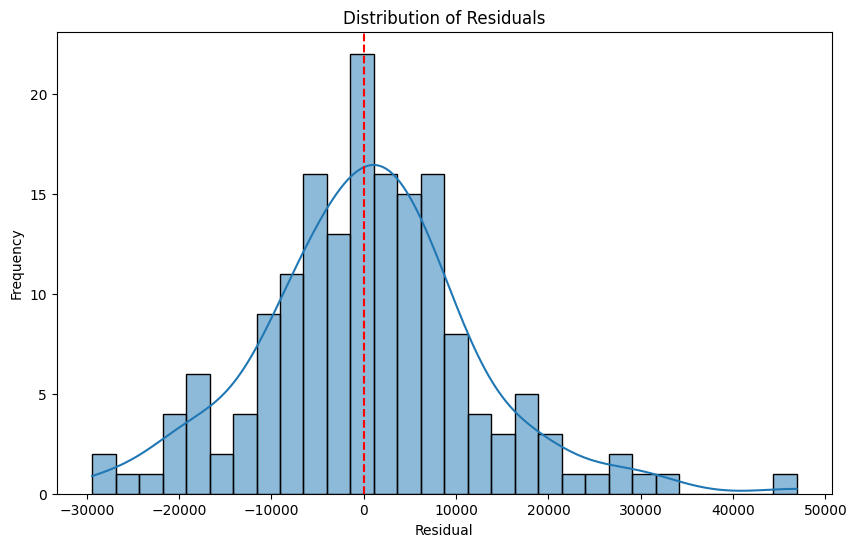

In [80]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

## Conclusion
In this project, we built and evaluated both a Linear Regression model and a Random Forest model to predict motorcycle resale prices based on various features such as age, mileage, and brand. After viewing the results of the linear regression model and performing hyperparameter tuning via `GridSearchCV`, we identified the optimal parameters for the model. We then evaluated the model using key statistical metrics such as mean squared error (MSE), mean absolute error (MAE), and R². The model showed improvement after tuning, showing that it was able to successfully find a relationship between the descriptive features and target feature. Although some statistics suggest overfitting, this could certainly be improved upon with additional feature enginerring or more sophisticated tuning techniques. Visualizations were used to further educate ourselves and confirm our suspicions. 